<h1>Homework 2</h1>

In [2]:
import random
import math
import numpy as np
import math

<h2>Problem 1: Perceptron</h2>

In [ ]:
# 1. and 2.
def generate_data(num_data):
    X = []
    y = []
    for i in range(num_data):
        x1 = random.random()
        x2 = random.random()
        X.append([x1, x2])
        if x1 > x2:
            y.append(1)
        else:
            y.append(-1)
    return X, y


def prediction(x, w):
    p = np.sign(w[0]*x[0]+w[1]*x[1])
    if p > 0:
        return 1
    else:
        return -1


def training(X, y, epoch, learning_rate, loss):
#     initialize weights
    weights = [0.0, 0.0]
    for i in range(epoch):
        for j in range(len(X)):
            if loss == 'hinge loss':
                if y[j]*(weights[0]*X[j][0] + weights[1]*X[j][1]) < 1:
                    weights[0] = weights[0] + learning_rate * y[j] * X[j][0]
                    weights[1] = weights[1] + learning_rate * y[j] * X[j][1]
            else:
                if y[j]*(weights[0]*X[j][0] + weights[1]*X[j][1]) < 0:
                    weights[0] = weights[0] + learning_rate * y[j] * X[j][0]
                    weights[1] = weights[1] + learning_rate * y[j] * X[j][1]
    return weights


def test_accuracy(X_test, y_test, W, loss):
    correct = 0
    for i in range(len(X_test)):
        predicted_y = prediction(X_test[i], W)
        if predicted_y == y_test[i]:
            correct += 1
    print(loss + ' accuracy is ' + str(correct/len(X_test)))
    
    
X, y = generate_data(10)
X_test, y_test = generate_data(5000)

# hyperparameter
epoch = 1000
learning_rate = 0.03

# perceptron
W1 = training(X, y, epoch, learning_rate, 'perceptron')
test_accuracy(X_test, y_test, W1, 'perceptron')

# hinge loss
W2 = training(X, y, epoch, learning_rate, 'hinge loss')
test_accuracy(X_test, y_test, W2, 'hinge loss')

perceptron accuracy is 0.5012
hinge loss accuracy is 0.9858


<p>3. Hinge loss function has better test accuracy since the loss function in perceptron criterion only includes misclassified points, whereas misclassfied and marginally classified points all contribute to the loss function in hinge loss. </p>

<p>4. Hinge loss would not change significantly since hinge loss would maximize the distance of separating hyperplane. </p>

<h2> Problem 2: Weight Initialization, Dead Neurons, Leaky ReLU</h2>

<p>1. Credit: https://intoli.com/blog/neural-network-initialization/</p>

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras import backend as K

from matplotlib import pyplot as plt
from matplotlib import rcParamsDefault


def grid_axes_it(n_plots, n_cols=3, enumerate=False, fig=None):
    """
    Iterate through Axes objects on a grid with n_cols columns and as many
    rows as needed to accommodate n_plots many plots.
    Args:
        n_plots: Number of plots to plot onto figure.
        n_cols: Number of columns to divide the figure into.
        fig: Optional figure reference.
    Yields:
        n_plots many Axes objects on a grid.
    """
    n_rows = n_plots / n_cols + int(n_plots % n_cols > 0)

    if not fig:
        default_figsize = rcParamsDefault['figure.figsize']
        fig = plt.figure(figsize=(
            default_figsize[0] * n_cols,
            default_figsize[1] * n_rows
        ))

    for i in range(1, n_plots + 1):
        ax = plt.subplot(int(n_rows), int(n_cols), i)
        yield ax


def create_mlp_model(
    n_hidden_layers,
    dim_layer,
    input_shape,
    n_classes,
    kernel_initializer,
    bias_initializer,
    activation,
):
    """Create Multi-Layer Perceptron with given parameters."""
    model = Sequential()
    model.add(Dense(dim_layer, input_shape=input_shape, kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    for i in range(n_hidden_layers):
        model.add(Dense(dim_layer, activation=activation, kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer))
    model.add(Dense(n_classes, activation='softmax', kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def create_cnn_model(input_shape, num_classes, kernel_initializer='glorot_uniform',
                     bias_initializer='zeros'):
    """Create CNN model similar to
       https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py."""
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(Conv2D(64, (3, 3), activation='relu',
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def compile_model(model):
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])
    return model


def get_init_id(init):
    """
    Returns string ID summarizing initialization scheme and its parameters.
    Args:
        init: Instance of some initializer from keras.initializers.
    """
    try:
        init_name = str(init).split('.')[2].split(' ')[0]
    except:
        init_name = str(init).split(' ')[0].replace('.', '_')

    param_list = []
    config = init.get_config()
    for k, v in config.items():
        if k == 'seed':
            continue
        param_list.append('{k}-{v}'.format(k=k, v=v))
    init_params = '__'.join(param_list)

    return '|'.join([init_name, init_params])


def get_activations(model, x, mode=0.0):
    """Extract activations with given model and input vector x."""
    outputs = [layer.output for layer in model.layers]
    activations = K.function([model.input], outputs)
    output_elts = activations(x)
    return output_elts


class LossHistory(keras.callbacks.Callback):
    """A custom keras callback for recording losses during network training."""

    def on_train_begin(self, logs={}):
        self.losses = []
        self.epoch_losses = []
        self.epoch_val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        self.epoch_losses.append(logs.get('loss'))
        self.epoch_val_losses.append(logs.get('val_loss'))

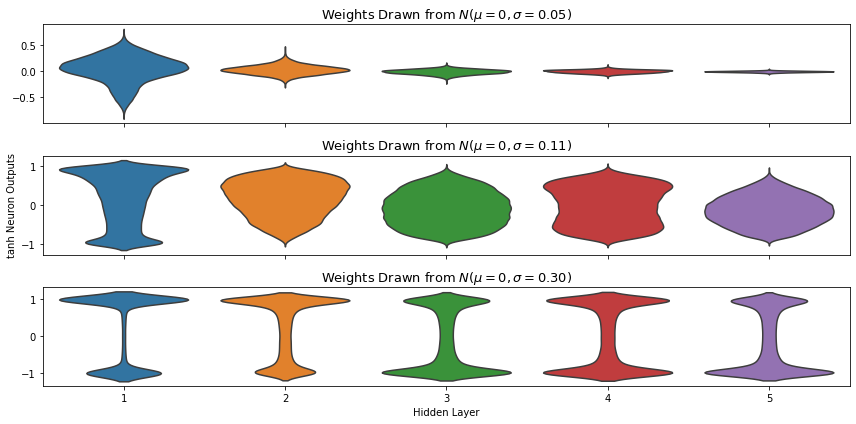

In [ ]:
# tanh activation with random normal distribution initializer
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras import initializers
from keras.datasets import mnist



seed = 10

# Number of points to plot
n_train = 1000
n_test = 100
n_classes = 10

# Network params
n_hidden_layers = 5
dim_layer = 100
batch_size = n_train
epochs = 1

# Load and prepare MNIST dataset.
n_train = 60000
n_test = 10000

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_test))
data_dim = 28 * 28

x_train = x_train.reshape(60000, 784).astype('float32')[:n_train]
x_test = x_test.reshape(10000, 784).astype('float32')[:n_train]
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Run the data through a few MLP models and save the activations from
# each layer into a Pandas DataFrame.
rows = []
sigmas = [0.05, 0.11, 0.30]
for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    activation = 'tanh'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("tanh Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

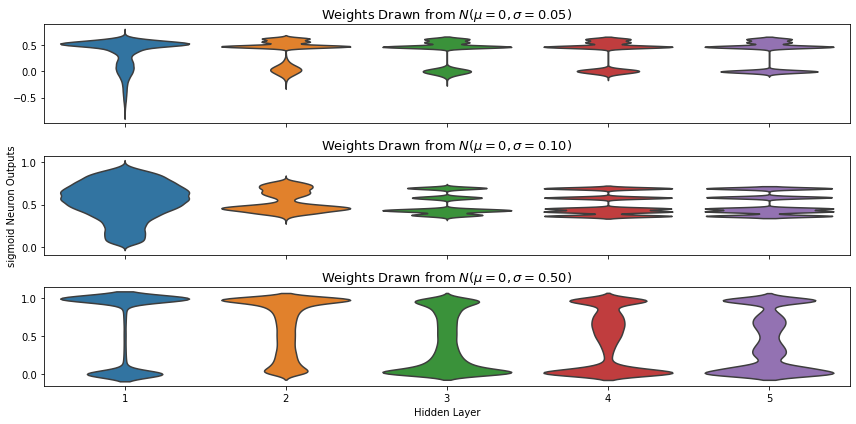

In [ ]:
# sigmoid activation with random normal distribution initializer
sigmas = [0.05, 0.10, 0.50]
for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    activation = 'sigmoid'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("sigmoid Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

<P> Explanation: From the above two figures, we can see when $\mu=0$ and $\sigma=0.05$, the gradients of weights are vanishing, so the sum of weights times x is 0, thus the results in tanh are around 0, and in sigmoid are around 0.5. The reason that the occurence of gradient vanishing is the weights in each layer are close to zero, so when we multiply weights in gradient descent, the weights become smaller and smaller in later layers.</p>

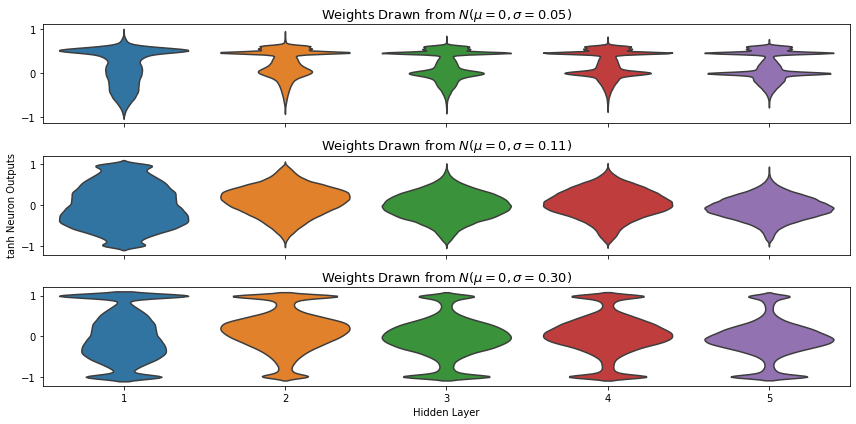

In [ ]:
# tanh activation with Xavier initializer
sigmas = [0.05, 0.11, 0.30]
for stddev in sigmas:
    init = initializers.GlorotNormal(seed=seed)
    activation = 'tanh'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("tanh Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

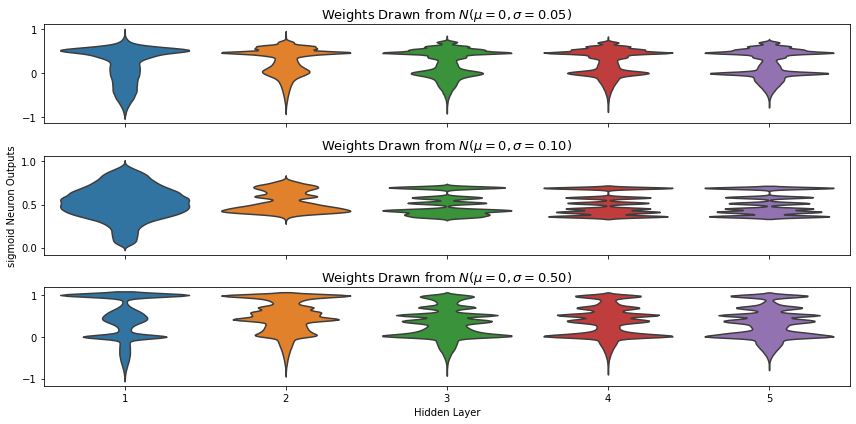

In [ ]:
# sigmoid activation with Xavier initializer
sigmas = [0.05, 0.10, 0.50]
for stddev in sigmas:
    init = initializers.GlorotNormal(seed=seed)
    activation = 'sigmoid'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("sigmoid Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

<p> Now, we can see the problem of vanishing gradient is alleviated by using Xavier initialization. </p>

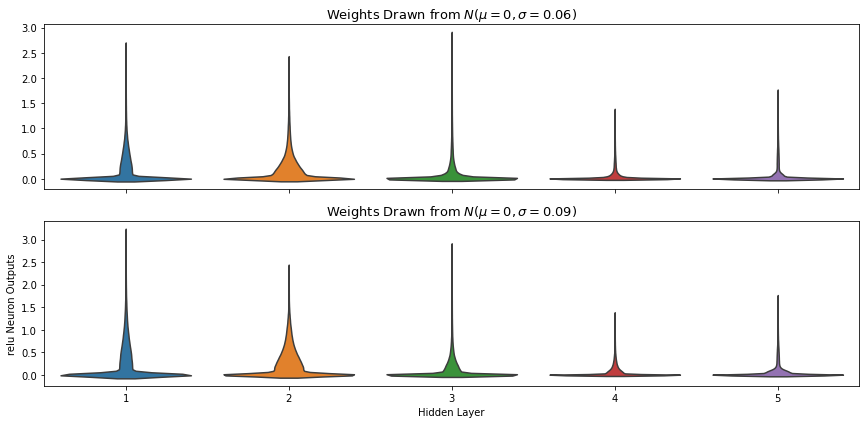

In [ ]:
# relu activation with random normal distribution initializer
sigmas = [0.06, 0.09]
for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    activation = 'relu'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("relu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

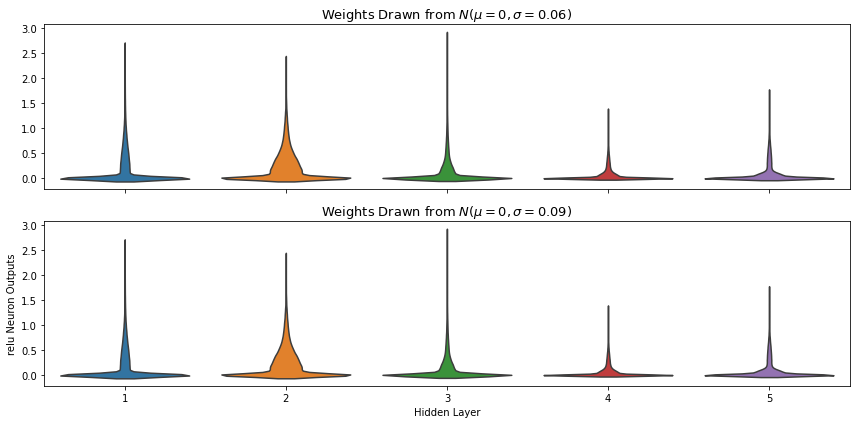

In [ ]:
# relu activation with Xavier initializer
sigmas = [0.06, 0.09]
for stddev in sigmas:
    init = initializers.GlorotNormal(seed=seed)
    activation = 'relu'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("relu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

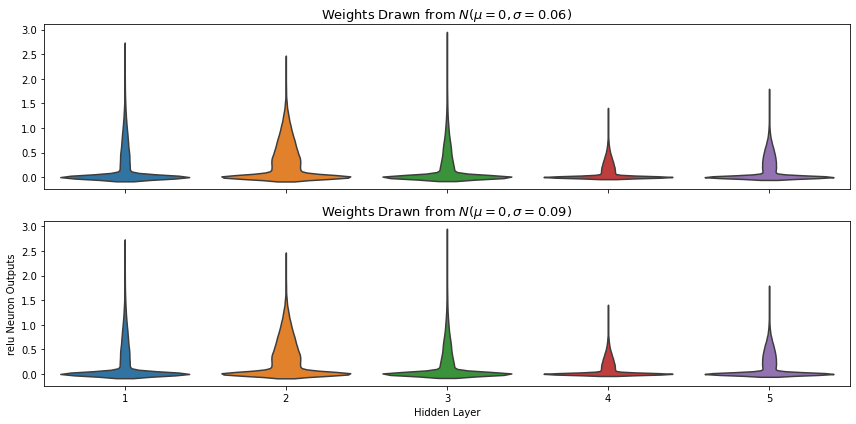

In [ ]:
# relu activation with He initializer
sigmas = [0.06, 0.09]
for stddev in sigmas:
    init = initializers.HeNormal(seed=seed)
    activation = 'relu'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("relu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

<P> From the above figures, we can know He initialization works better than Glorot initialization since half of values in ReLU is zero, makes half of the variance be removed, so He initialization doubles the variances of weights to compensate it. </p>

<p>2. The function I choose is $f_1(x)=|x|$.</p>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm


def generate_training_data(num):
    X = np.zeros((num, 1))
    y = np.zeros((num, 1))
    for i in range(num):
        t = random.uniform(-math.sqrt(7), math.sqrt(7))
        X[i] = t
        y[i] = abs(t)
    return X, y


def train_model(X, y, test_X):
    model = keras.Sequential(
        [
            layers.Dense(2, activation="relu", kernel_initializer='HeNormal'),
            layers.Dense(2, activation="relu", kernel_initializer='HeNormal'),
            layers.Dense(2, activation="relu", kernel_initializer='HeNormal'),
            layers.Dense(2, activation="relu", kernel_initializer='HeNormal'),
            layers.Dense(2, activation="relu", kernel_initializer='HeNormal'),
            layers.Dense(2, activation="relu", kernel_initializer='HeNormal'),
            layers.Dense(2, activation="relu", kernel_initializer='HeNormal'),
            layers.Dense(2, activation="relu", kernel_initializer='HeNormal'),
            layers.Dense(2, activation="relu", kernel_initializer='HeNormal'),
            layers.Dense(2, activation="relu", kernel_initializer='HeNormal'),
            layers.Dense(1, name="output"),
        ]
    )
    
    model.compile(optimizer="SGD", loss="mse", metrics=["mse"])
    model.fit(x=X, y=y, epochs=7, batch_size=64, verbose=0)
    
    y_pred = model.predict(test_X, verbose=0)
    
    if np.var(y_pred) < 1e-5:
        return 1
    else:
        return 0
    
    
collapse = 0
for i in tqdm(range(1000)):
    X, y = generate_training_data(3000)
    test_X, test_y = generate_training_data(100)
    collapse += train_model(X, y, test_X)
print('Collapse rate is ' + str(collapse/1000))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:42<00:00,  1.12s/it]

Collapse rate is 0.957


<p> My result is also over 90% as was reported in Lu et al.</p>

In [ ]:
# 3.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm


def generate_training_data(num):
    X = np.zeros((num, 1))
    y = np.zeros((num, 1))
    for i in range(num):
        t = random.uniform(-math.sqrt(7), math.sqrt(7))
        X[i] = t
        y[i] = abs(t)
    return X, y


def train_model(X, y, test_X):
    model = keras.Sequential()
    model.add(layers.Dense(2))
    tf.keras.layers.LeakyReLU(alpha=0.01)
    model.add(layers.Dense(2))
    tf.keras.layers.LeakyReLU(alpha=0.01)
    model.add(layers.Dense(2))
    tf.keras.layers.LeakyReLU(alpha=0.01)
    model.add(layers.Dense(2))
    tf.keras.layers.LeakyReLU(alpha=0.01)
    model.add(layers.Dense(2))
    tf.keras.layers.LeakyReLU(alpha=0.01)
    model.add(layers.Dense(2))
    tf.keras.layers.LeakyReLU(alpha=0.01)
    model.add(layers.Dense(2))
    tf.keras.layers.LeakyReLU(alpha=0.01)
    model.add(layers.Dense(2))
    tf.keras.layers.LeakyReLU(alpha=0.01)
    model.add(layers.Dense(2))
    tf.keras.layers.LeakyReLU(alpha=0.01)
    model.add(layers.Dense(2))
    tf.keras.layers.LeakyReLU(alpha=0.01)
    model.add(layers.Dense(1))
    
    model.compile(optimizer="SGD", loss="mse", metrics=["mse"])
    model.fit(x=X, y=y, epochs=7, batch_size=64, verbose=0)
    
    y_pred = model.predict(test_X, verbose=0)
    
    if np.var(y_pred) < 1e-5:
        return 1
    else:
        return 0
    
    
collapse = 0
for i in tqdm(range(1000)):
    X, y = generate_training_data(3000)
    test_X, test_y = generate_training_data(100)
    collapse += train_model(X, y, test_X)
print('Collapse rate is ' + str(collapse/1000))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [21:10<00:00,  1.27s/it]

Collapse rate is 0.126


<p> The collapse rate decrease from 95.7% to 12.6%, so Leaky ReLU help in preventing dying neurons. </p>

<h2>Problem 3: Batch Normalization, Dropout, MNIST </h2>

<p>1. Co-adaptation means the behaviors of hidden units in neural networks are highly correlated, whereas we want each neuron can learn unique feature. Covariance-shift refers to the distribution of inputs in layers changes due to the change of network parameters during training. </p>

In [ ]:
# 2.
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# convert integers to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalization
X_train = X_train/255.0
X_test = X_test/255.0

# reshape training data to 4D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# padding due to the input shape of LeNet-5 is (32, 32, 1)
X_train = tf.pad(X_train, [[0, 0], [2, 2], [2, 2], [0, 0]], "CONSTANT")
X_test = tf.pad(X_test, [[0, 0], [2, 2], [2, 2], [0, 0]], "CONSTANT")

# define model
model = Sequential()

# input layer standard normalization
model.add(keras.layers.LayerNormalization(trainable=True, name='standardnorm'))

# convolutional layer 1
model.add(keras.layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(32,32,1), padding='valid'))
model.add(keras.layers.BatchNormalization(trainable=True, name='batchnorm_1'))

# pooling layer 1
model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# convolutional layer 2
model.add(keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(keras.layers.BatchNormalization(trainable=True, name='batchnorm_2'))

# pooling layer 2
model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# convolutional layer 3
model.add(keras.layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(keras.layers.BatchNormalization(trainable=True, name='batchnorm_3'))

# flatten
model.add(keras.layers.Flatten())

# fully connected layer
model.add(keras.layers.Dense(84, activation='tanh'))
model.add(keras.layers.BatchNormalization(trainable=True, name='batchnorm_4'))
          
# output layer
model.add(keras.layers.Dense(10, activation='softmax'))
          
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])
          
model.fit(x=X_train, y=y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

res = model.evaluate(X_test, y_test)
print('accuracy is ' + str(res[1]))

Epoch 1/10
469/469 [==============================] - 14s 28ms/step - loss: 2.3017 - accuracy: 0.1119 - val_loss: 27.6457 - val_accuracy: 0.0980
Epoch 2/10
469/469 [==============================] - 13s 28ms/step - loss: 2.3013 - accuracy: 0.1124 - val_loss: 87.9409 - val_accuracy: 0.0892
Epoch 3/10
469/469 [==============================] - 13s 28ms/step - loss: 2.3013 - accuracy: 0.1124 - val_loss: 95.2264 - val_accuracy: 0.0958
Epoch 4/10
469/469 [==============================] - 13s 28ms/step - loss: 2.3012 - accuracy: 0.1124 - val_loss: 23.4042 - val_accuracy: 0.0892
Epoch 5/10
469/469 [==============================] - 13s 27ms/step - loss: 2.3012 - accuracy: 0.1124 - val_loss: 42.7083 - val_accuracy: 0.0982
Epoch 6/10
469/469 [==============================] - 12s 26ms/step - loss: 2.3012 - accuracy: 0.1124 - val_loss: 61.1950 - val_accuracy: 0.0980
Epoch 7/10
469/469 [==============================] - 12s 26ms/step - loss: 2.3012 - accuracy: 0.1124 - val_loss: 92.9774 - val_ac

In [ ]:
# learned batch norm parameters
model.summary()
print(model.get_layer('batchnorm_1').weights)
print(model.get_layer('batchnorm_2').weights)
print(model.get_layer('batchnorm_3').weights)
print(model.get_layer('batchnorm_4').weights)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 standardnorm (LayerNormaliz  (None, 32, 32, 1)        2         
 ation)                                                          
                                                                 
 conv2d_37 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 28, 28, 6)        24        
 tion)                                                           
                                                                 
 average_pooling2d_24 (Avera  (None, 14, 14, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_38 (Conv2D)          (None, 10, 10, 16)        2416      
                                                     

In [ ]:
# 3.
from tensorflow import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# convert integers to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalization
X_train = X_train/255.0
X_test = X_test/255.0

# reshape training data to 4D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# padding due to the input shape of LeNet-5 is (32, 32, 1)
X_train = tf.pad(X_train, [[0, 0], [2, 2], [2, 2], [0, 0]], "CONSTANT")
X_test = tf.pad(X_test, [[0, 0], [2, 2], [2, 2], [0, 0]], "CONSTANT")

# define model
model = Sequential()

model.add(keras.layers.BatchNormalization(trainable=True, name='batchnorm_1'))

# convolutional layer 1
model.add(keras.layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(32,32,1), padding='valid'))
model.add(keras.layers.BatchNormalization(trainable=True, name='batchnorm_2'))

# pooling layer 1
model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# convolutional layer 2
model.add(keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(keras.layers.BatchNormalization(trainable=True, name='batchnorm_3'))

# pooling layer 2
model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# convolutional layer 3
model.add(keras.layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(keras.layers.BatchNormalization(trainable=True, name='batchnorm_4'))

# flatten
model.add(keras.layers.Flatten())

# fully connected layer
model.add(keras.layers.Dense(84, activation='tanh'))
model.add(keras.layers.BatchNormalization(trainable=True, name='batchnorm_5'))
          
# output layer
model.add(keras.layers.Dense(10, activation='softmax'))
          
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])
          
model.fit(x=X_train, y=y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

res = model.evaluate(X_test, y_test)
print('accuracy is ' + str(res[1]))

Epoch 1/10
469/469 [==============================] - 18s 37ms/step - loss: 0.2669 - accuracy: 0.9273 - val_loss: 0.1407 - val_accuracy: 0.9619
Epoch 2/10
469/469 [==============================] - 17s 36ms/step - loss: 0.1129 - accuracy: 0.9695 - val_loss: 0.0863 - val_accuracy: 0.9781
Epoch 3/10
469/469 [==============================] - 17s 36ms/step - loss: 0.0804 - accuracy: 0.9780 - val_loss: 0.0637 - val_accuracy: 0.9818
Epoch 4/10
469/469 [==============================] - 16s 35ms/step - loss: 0.0654 - accuracy: 0.9819 - val_loss: 0.0588 - val_accuracy: 0.9825
Epoch 5/10
469/469 [==============================] - 17s 35ms/step - loss: 0.0560 - accuracy: 0.9844 - val_loss: 0.0493 - val_accuracy: 0.9860
Epoch 6/10
469/469 [==============================] - 17s 36ms/step - loss: 0.0501 - accuracy: 0.9858 - val_loss: 0.0453 - val_accuracy: 0.9861
Epoch 7/10
469/469 [==============================] - 16s 35ms/step - loss: 0.0456 - accuracy: 0.9873 - val_loss: 0.0453 - val_accuracy:

In [ ]:
# learned batch norm parameters
model.summary()
print(model.get_layer('batchnorm_1').weights)
print(model.get_layer('batchnorm_2').weights)
print(model.get_layer('batchnorm_3').weights)
print(model.get_layer('batchnorm_4').weights)
print(model.get_layer('batchnorm_5').weights)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batchnorm_1 (BatchNormaliza  (None, 32, 32, 1)        4         
 tion)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 28, 28, 6)        24        
 tion)                                                           
                                                                 
 average_pooling2d_26 (Avera  (None, 14, 14, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_41 (Conv2D)          (None, 10, 10, 16)        2416      
                                                     

<AxesSubplot:xlabel='layer', ylabel='value'>

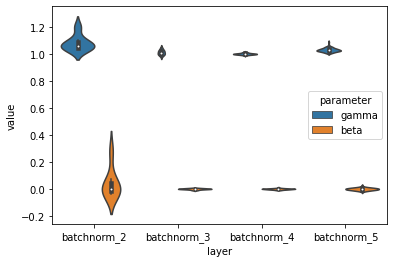

In [ ]:
# plot
import pandas as pd
import seaborn

gamma_1 = model.get_layer('batchnorm_1').weights[0]
beta_1 = model.get_layer('batchnorm_1').weights[1]
gamma_2 = model.get_layer('batchnorm_2').weights[0]
beta_2 = model.get_layer('batchnorm_2').weights[1]
gamma_3 = model.get_layer('batchnorm_3').weights[0]
beta_3 = model.get_layer('batchnorm_3').weights[1]
gamma_4 = model.get_layer('batchnorm_4').weights[0]
beta_4 = model.get_layer('batchnorm_4').weights[1]
gamma_5 = model.get_layer('batchnorm_5').weights[0]
beta_5 = model.get_layer('batchnorm_5').weights[1]

df = pd.DataFrame(data={
    'layer': ['batchnorm_2'] * 2 + ['batchnorm_2'] * 12 + ['batchnorm_3'] * 32 + ['batchnorm_4'] * 240 + ['batchnorm_5'] * 168,
    'parameter': ['gamma'] * 1 + ['beta'] * 1 + ['gamma'] * 6 + ['beta'] * 6 + ['gamma'] * 16 + ['beta'] * 16 + ['gamma'] * 120 + ['beta'] * 120 + ['gamma'] * 84 + ['beta'] * 84,
    'value': np.concatenate((gamma_1, beta_1, gamma_2, beta_2, gamma_3, beta_3, gamma_4, beta_4, gamma_5, beta_5))})

seaborn.violinplot(x='layer', y='value', hue='parameter', data=df)

<p> Compared the train/test accuracy and loss of part 2 and part 3, the accuracy in part 3 is greatly higher and loss is smaller, so batchnomalization for input layer improve performance. </p>

In [ ]:
# 4.
from tensorflow import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# convert integers to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalization
X_train = X_train/255.0
X_test = X_test/255.0

# reshape training data to 4D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# padding due to the input shape of LeNet-5 is (32, 32, 1)
X_train = tf.pad(X_train, [[0, 0], [2, 2], [2, 2], [0, 0]], "CONSTANT")
X_test = tf.pad(X_test, [[0, 0], [2, 2], [2, 2], [0, 0]], "CONSTANT")

# define model
model = Sequential()

model.add(keras.layers.Dropout(0.2))

# convolutional layer 1
model.add(keras.layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(32,32,1), padding='valid'))

# pooling layer 1
model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(keras.layers.Dropout(0.5))

# convolutional layer 2
model.add(keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

# pooling layer 2
model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(keras.layers.Dropout(0.5))

# convolutional layer 3
model.add(keras.layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(keras.layers.Dropout(0.5))

# flatten
model.add(keras.layers.Flatten())

# fully connected layer
model.add(keras.layers.Dense(84, activation='tanh'))
model.add(keras.layers.Dropout(0.5))
          
# output layer
model.add(keras.layers.Dense(10, activation='softmax'))
          
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])
          
model.fit(x=X_train, y=y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

res = model.evaluate(X_test, y_test)
print('accuracy is ' + str(res[1]))

Epoch 1/10
469/469 [==============================] - 10s 19ms/step - loss: 1.7061 - accuracy: 0.4378 - val_loss: 0.7386 - val_accuracy: 0.8261
Epoch 2/10
469/469 [==============================] - 9s 19ms/step - loss: 0.9373 - accuracy: 0.6939 - val_loss: 0.4723 - val_accuracy: 0.8773
Epoch 3/10
469/469 [==============================] - 9s 19ms/step - loss: 0.7796 - accuracy: 0.7457 - val_loss: 0.3953 - val_accuracy: 0.8907
Epoch 4/10
469/469 [==============================] - 9s 19ms/step - loss: 0.7100 - accuracy: 0.7713 - val_loss: 0.3590 - val_accuracy: 0.8964
Epoch 5/10
469/469 [==============================] - 9s 19ms/step - loss: 0.6658 - accuracy: 0.7876 - val_loss: 0.3359 - val_accuracy: 0.9042
Epoch 6/10
469/469 [==============================] - 9s 19ms/step - loss: 0.6360 - accuracy: 0.7958 - val_loss: 0.3211 - val_accuracy: 0.9062
Epoch 7/10
469/469 [==============================] - 9s 19ms/step - loss: 0.6120 - accuracy: 0.8058 - val_loss: 0.3050 - val_accuracy: 0.911

<p> As we can see, the test accuracy is lower than part 2 and part 3 when using dropout. </p>

In [ ]:
# 5.
from tensorflow import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# convert integers to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalization
X_train = X_train/255.0
X_test = X_test/255.0

# reshape training data to 4D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# padding due to the input shape of LeNet-5 is (32, 32, 1)
X_train = tf.pad(X_train, [[0, 0], [2, 2], [2, 2], [0, 0]], "CONSTANT")
X_test = tf.pad(X_test, [[0, 0], [2, 2], [2, 2], [0, 0]], "CONSTANT")

# define model
model = Sequential()

model.add(keras.layers.BatchNormalization(trainable=True, name='batchnorm_1'))
model.add(keras.layers.Dropout(0.2))

# convolutional layer 1
model.add(keras.layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(32,32,1), padding='valid'))
model.add(keras.layers.BatchNormalization(trainable=True, name='batchnorm_2'))

# pooling layer 1
model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(keras.layers.Dropout(0.5))

# convolutional layer 2
model.add(keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(keras.layers.BatchNormalization(trainable=True, name='batchnorm_3'))

# pooling layer 2
model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(keras.layers.Dropout(0.5))

# convolutional layer 3
model.add(keras.layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(keras.layers.BatchNormalization(trainable=True, name='batchnorm_4'))
model.add(keras.layers.Dropout(0.5))

# flatten
model.add(keras.layers.Flatten())

# fully connected layer
model.add(keras.layers.Dense(84, activation='tanh'))
model.add(keras.layers.BatchNormalization(trainable=True, name='batchnorm_5'))
model.add(keras.layers.Dropout(0.5))
          
# output layer
model.add(keras.layers.Dense(10, activation='softmax'))
          
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])
          
model.fit(x=X_train, y=y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

res = model.evaluate(X_test, y_test)
print('accuracy is ' + str(res[1]))

Epoch 1/10
469/469 [==============================] - 19s 40ms/step - loss: 1.1574 - accuracy: 0.6277 - val_loss: 0.3534 - val_accuracy: 0.8923
Epoch 2/10
469/469 [==============================] - 19s 40ms/step - loss: 0.7187 - accuracy: 0.7699 - val_loss: 0.2841 - val_accuracy: 0.9142
Epoch 3/10
469/469 [==============================] - 19s 40ms/step - loss: 0.6070 - accuracy: 0.8066 - val_loss: 0.2485 - val_accuracy: 0.9235
Epoch 4/10
469/469 [==============================] - 18s 39ms/step - loss: 0.5285 - accuracy: 0.8356 - val_loss: 0.2085 - val_accuracy: 0.9379
Epoch 5/10
469/469 [==============================] - 18s 39ms/step - loss: 0.4741 - accuracy: 0.8520 - val_loss: 0.1885 - val_accuracy: 0.9431
Epoch 6/10
469/469 [==============================] - 18s 39ms/step - loss: 0.4309 - accuracy: 0.8662 - val_loss: 0.1618 - val_accuracy: 0.9503
Epoch 7/10
469/469 [==============================] - 19s 40ms/step - loss: 0.4022 - accuracy: 0.8754 - val_loss: 0.1479 - val_accuracy:

<p> The result shows that when using both batch normalization and dropout, the performance is better than using dropout alone, but worse than using batch normalization alone. </p>

<h2>Problem 4: Universal Approximators: Depth vs. Width </h2>

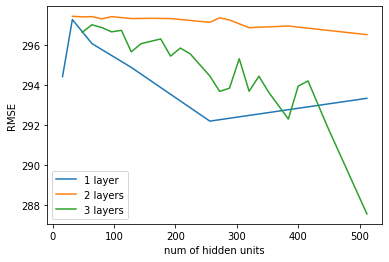

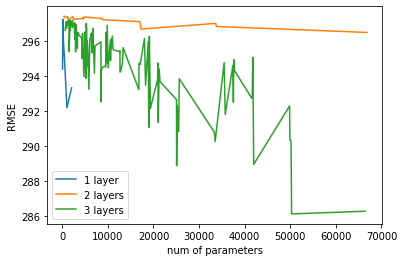

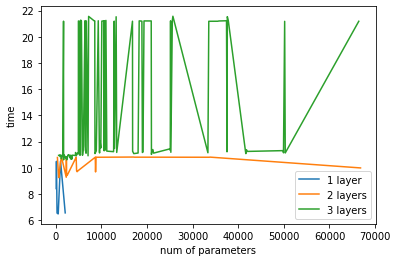

In [4]:
# 1. and 2.
from sklearn.model_selection import train_test_split
import sklearn
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import backend as K
from keras.losses import mean_squared_error
import matplotlib.pyplot as plt
from keras import initializers
import tensorflow as tf
import time

X = np.zeros((100000, 2))
y = np.zeros((100000, 1))

# generate data
for i in range(100000):
    x1 = random.uniform(-512, 512)
    x2 = random.uniform(-512, 512)
    X[i][0] = x1
    X[i][1] = x2
    y[i] = -(x2+47) * math.sin(math.sqrt(abs(x1/2+(x2+47)))) - x1 * math.sin(math.sqrt(abs(x1-(x2+47)))) + np.random.normal(0, math.sqrt(0.3))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

# build model
def build_model(combination, name):
    units_dict = {}
    num_param_dict = {}
    time_dict = {}
    for units in combination:
        total_loss = 0.0
        for i in range(len(combination[units])):
            num_param = 0
            now_param = 2
            network_architect = combination[units][i]
            model = Sequential()
            for j in range(len(network_architect)):
                num_param += now_param * network_architect[j] + network_architect[j]
                now_param = network_architect[j]
                model.add(keras.layers.Dense(network_architect[j], activation='relu', kernel_initializer=initializers.HeNormal(seed=None), bias_initializer=initializers.Zeros()))
                if len(network_architect) > 1:
                    model.add(keras.layers.BatchNormalization(trainable=True))
            num_param += now_param + 1
            model.add(keras.layers.Dense(1))
            
            optimizer = tf.keras.optimizers.SGD(nesterov=True, learning_rate=1e-6)
          
            model.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

            time1 = time.time()
            model.fit(x=X_train, y=y_train, epochs=2000, batch_size=1000, verbose=0)
            time2 = time.time()

            pred = model.predict(X_test, verbose=0)

            res = np.sqrt(sklearn.metrics.mean_squared_error(y_test, pred))
            
            if num_param not in num_param_dict:
                num_param_dict[num_param] = res
                time_dict[num_param] = time2-time1
            
            total_loss += res
        units_dict[units] = total_loss / len(combination[units])
    
    u = np.array(sorted(units_dict.items(), key=lambda x: x[0]))
    plt.figure(1)
    plt.plot(u.T[0], u.T[1], label=name)
    plt.legend()
    plt.xlabel('num of hidden units')
    plt.ylabel('RMSE')
    
    p = np.array(sorted(num_param_dict.items(), key=lambda x: x[0]))
    plt.figure(2)
    plt.plot(p.T[0], p.T[1], label=name)
    plt.legend()
    plt.xlabel('num of parameters')
    plt.ylabel('RMSE')

    ti = np.array(sorted(time_dict.items(), key=lambda x: x[0]))
    plt.figure(3)
    plt.plot(ti.T[0], ti.T[1], label=name)
    plt.legend()
    plt.xlabel('num of parameters')
    plt.ylabel('time')


num_units = [16, 32, 64, 128, 256, 512]
# one layer
combination = {}
total_unit = 0
l = []
for i in num_units:
    total_unit = 0
    l = []
    total_unit += i
    l.append(i)
    if total_unit not in combination:
        combination[total_unit] = [l]
build_model(combination, '1 layer')
                     
# two layers
combination = {}
total_unit = 0
l = []
for i in num_units:
    for j in num_units:
        total_unit = i + j
        l = [i, j]
        if total_unit <= 512:
            if total_unit not in combination:
                combination[total_unit] = [l]
            else:
                combination[total_unit].append(l)
build_model(combination, '2 layers')

# three layers
combination = {}
total_unit = 0
l = []
for i in num_units:
    for j in num_units:
        for k in num_units:
            total_unit = i + j + k
            l = [i, j, k]
            if total_unit <= 512:
                if total_unit not in combination:
                    combination[total_unit] = [l]
                else:
                    combination[total_unit].append(l)
build_model(combination, '3 layers')

plt.show() 

<p> From the aboved figures, with the increasing number of parameters, RMSE would drop. Also, for the same hidden units, the ability of representation of deeper network is higher than shallower network. Movemore, there is also a similar tradeoff in training time, which demonstrates more parameters need more time to learn. </p>

<h2>Problem 5: Learning Rate, Batch Size, FashionMNIST</h2>

<p> Credit to https://pyimagesearch.com/2019/08/05/keras-learning-rate-finder </p>

[INFO] loading Fashion MNIST data...
4422102/4422102 [==============================] - 0s 0us/step
[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


[INFO] training network...
Epoch 1/5
937/937 [==============================] - 59s 50ms/step - loss: 0.7113 - accuracy: 0.7452 - val_loss: 1.6198 - val_accuracy: 0.5951
Epoch 2/5
937/937 [==============================] - 52s 56ms/step - loss: 0.6418 - accuracy: 0.7821 - val_loss: 6.0202 - val_accuracy: 0.5816
Epoch 3/5
937/937 [==============================] - 45s 48ms/step - loss: 0.8203 - accuracy: 0.7251 - val_loss: 0.7462 - val_accuracy: 0.7997
Epoch 4/5
937/937 [==============================] - 47s 50ms/step - loss: 0.9928 - accuracy: 0.6592 - val_loss: 0.7538 - val_accuracy: 0.7850
Epoch 5/5
937/937 [==============================] - 45s 48ms/step - loss: 1.0985 - accuracy: 0.6137 - val_loss: 0.6277 - val_accuracy: 0.7703
[INFO] evaluating network...
157/157 [==============================] - 2s 12ms/step
[INFO] finding learning rate...
Epoch 1/3
938/938 [==============================] - 43s 46ms/step - loss: 3.4058 - accuracy: 0.4459
Epoch 2/3
938/938 [=====================

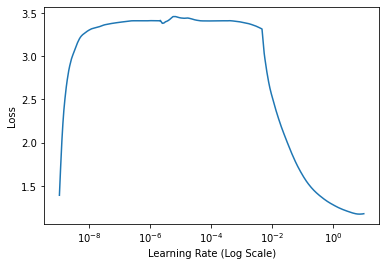

In [1]:
# 1.
# import the necessary packages
from learningratefinder import LearningRateFinder
from minigooglenet import MiniGoogLeNet
from clr_callback import CyclicLR
import config
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

sys.argv=['']
ap = argparse.ArgumentParser()
ap.add_argument("-f", "--lr-find", type=int, default=0,
	help="whether or not to find optimal learning rate")
args = vars(ap.parse_args())

# load the training and testing data
print("[INFO] loading Fashion MNIST data...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
# Fashion MNIST images are 28x28 but the network we will be training
# is expecting 32x32 images
trainX = np.array([cv2.resize(x, (32, 32)) for x in trainX])
testX = np.array([cv2.resize(x, (32, 32)) for x in testX])
# scale the pixel intensities to the range [0, 1]
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0
# reshape the data matrices to include a channel dimension (required
# for training)
trainX = trainX.reshape((trainX.shape[0], 32, 32, 1))
testX = testX.reshape((testX.shape[0], 32, 32, 1))
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
# construct the image generator for data augmentation
aug = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, fill_mode="nearest")

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=config.MIN_LR, momentum=0.9)
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# otherwise, we have already defined a learning rate space to train
# over, so compute the step size and initialize the cyclic learning
# rate method
stepSize = config.STEP_SIZE * (trainX.shape[0] // config.BATCH_SIZE)
clr = CyclicLR(
	mode=config.CLR_METHOD,
	base_lr=config.MIN_LR,
	max_lr=config.MAX_LR,
	step_size=stepSize)
# train the network
print("[INFO] training network...")
H = model.fit(
	x=aug.flow(trainX, trainY, batch_size=config.BATCH_SIZE),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // config.BATCH_SIZE,
	epochs=config.NUM_EPOCHS,
	callbacks=[clr],
	verbose=1)
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=config.BATCH_SIZE)

# initialize the learning rate finder and then train with learning
# rates ranging from 1e-10 to 1e+1
print("[INFO] finding learning rate...")
lrf = LearningRateFinder(model)
lrf.find(
    aug.flow(trainX, trainY, batch_size=config.BATCH_SIZE),
    1e-9, 10,
    stepsPerEpoch=np.ceil((len(trainX) / float(config.BATCH_SIZE))),
    batchSize=config.BATCH_SIZE)
# plot the loss for the various learning rates and save the
# resulting plot to disk
lrf.plot_loss()
# gracefully exit the script so we can adjust our learning rates
# in the config and then train the network for our full set of
# epochs
print("[INFO] learning rate finder complete")
print("[INFO] examine plot and adjust learning rates before training")

<p> From the figure, we can identify $lr_{min}=1e-2$, $lr_{max}=10$.

[INFO] compiling model...
[INFO] training network...
Epoch 1/5
  6/937 [..............................] - ETA: 53s - loss: 2.4138 - accuracy: 0.1380 

937/937 [==============================] - 49s 50ms/step - loss: 0.7012 - accuracy: 0.7483 - val_loss: 1.5039 - val_accuracy: 0.6915
Epoch 2/5
937/937 [==============================] - 45s 48ms/step - loss: 0.6592 - accuracy: 0.7743 - val_loss: 5.0417 - val_accuracy: 0.5191
Epoch 3/5
937/937 [==============================] - 45s 48ms/step - loss: 0.8683 - accuracy: 0.7060 - val_loss: 1.0330 - val_accuracy: 0.6825
Epoch 4/5
937/937 [==============================] - 45s 47ms/step - loss: 0.9942 - accuracy: 0.6509 - val_loss: 17.0605 - val_accuracy: 0.2795
Epoch 5/5
937/937 [==============================] - 46s 49ms/step - loss: 1.0011 - accuracy: 0.6550 - val_loss: 0.8676 - val_accuracy: 0.7404
[INFO] evaluating network...
157/157 [==============================] - 2s 11ms/step


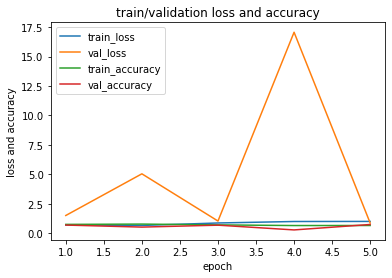

In [9]:
# 2.
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=1e-2, momentum=0.9)
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# otherwise, we have already defined a learning rate space to train
# over, so compute the step size and initialize the cyclic learning
# rate method
stepSize = config.STEP_SIZE * (trainX.shape[0] // config.BATCH_SIZE)
clr = CyclicLR(
	mode=config.CLR_METHOD,
	base_lr=1e-2,
	max_lr=10,
	step_size=stepSize)
# train the network
print("[INFO] training network...")
H = model.fit(
	x=aug.flow(trainX, trainY, batch_size=config.BATCH_SIZE),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // config.BATCH_SIZE,
	epochs=config.NUM_EPOCHS,
	callbacks=[clr],
	verbose=1)
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=config.BATCH_SIZE)

x_axis = np.arange(1, 6)
plt.plot(x_axis, H.history["loss"], label="train_loss")
plt.plot(x_axis, H.history["val_loss"], label="val_loss")
plt.plot(x_axis, H.history["accuracy"], label="train_accuracy")
plt.plot(x_axis, H.history["val_accuracy"], label="val_accuracy")
plt.title("train/validation loss and accuracy")
plt.xlabel("epoch")
plt.ylabel("loss and accuracy")
plt.legend()
plt.show()

[INFO] loading Fashion MNIST data...


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/5
1875/1875 [==============================] - ETA: 0s - batch: 937.0000 - size: 32.0000 - loss: 17.7454 - accuracy: 0.1016

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1875/1875 [==============================] - 136s 69ms/step - batch: 937.0000 - size: 32.0000 - loss: 17.7454 - accuracy: 0.1016 - val_loss: 4.9432 - val_accuracy: 0.1000
Epoch 2/5
1875/1875 [==============================] - 111s 59ms/step - batch: 937.0000 - size: 32.0000 - loss: 6.3437 - accuracy: 0.1015 - val_loss: 7.4780 - val_accuracy: 0.1000
Epoch 3/5
1875/1875 [==============================] - 116s 62ms/step - batch: 937.0000 - size: 32.0000 - loss: 6.3960 - accuracy: 0.0993 - val_loss: 11.5254 - val_accuracy: 0.1000
Epoch 4/5
1875/1875 [==============================] - 148s 79ms/step - batch: 937.0000 - size: 32.0000 - loss: 5.9027 - accuracy: 0.0997 - val_loss: 5.2896 - val_accuracy: 0.1000
Epoch 5/5
1875/1875 [==============================] - 134s 71ms/step - batch: 937.0000 - size: 32.0000 - loss: 6.1242 - accuracy: 0.0981 - val_loss: 5.4443 - val_accuracy: 0.1000


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Epoch 1/5
468/468 [==============================] - 63s 130ms/step - batch: 233.5000 - size: 127.9316 - loss: 2.8086 - accuracy: 0.1004 - val_loss: 2.5421 - val_accuracy: 0.1000
Epoch 2/5
468/468 [==============================] - 52s 112ms/step - batch: 233.5000 - size: 127.9316 - loss: 2.5641 - accuracy: 0.1001 - val_loss: 2.4151 - val_accuracy: 0.1000
Epoch 3/5
468/468 [==============================] - 54s 115ms/step - batch: 233.5000 - size: 127.9316 - loss: 2.6400 - accuracy: 0.1001 - val_loss: 2.6727 - val_accuracy: 0.1000
Epoch 4/5
468/468 [==============================] - 54s 115ms/step - batch: 233.5000 - size: 127.9316 - loss: 2.5959 - accuracy: 0.1000 - val_loss: 2.5801 - val_accuracy: 0.1000
Epoch 5/5
468/468 [==============================] - 54s 116ms/step - batch: 233.5000 - size: 127.9316 - loss: 2.5914 - accuracy: 0.1015 - val_loss: 2.6409 - val_accuracy: 0.1000
Epoch 1/5
117/117 [==============================] - 47s 354ms/step - batch: 58.0000 - size: 508.4444 - l

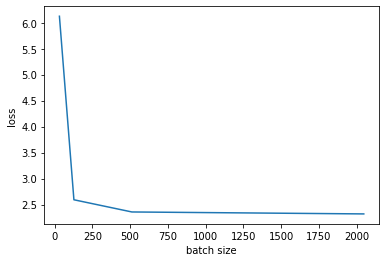

In [5]:
# 3.
from learningratefinder import LearningRateFinder
from minigooglenet import MiniGoogLeNet
from clr_callback import CyclicLR
import config
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

sys.argv=['']
ap = argparse.ArgumentParser()
ap.add_argument("-f", "--lr-find", type=int, default=0,
	help="whether or not to find optimal learning rate")
args = vars(ap.parse_args())

# load the training and testing data
print("[INFO] loading Fashion MNIST data...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
# Fashion MNIST images are 28x28 but the network we will be training
# is expecting 32x32 images
trainX = np.array([cv2.resize(x, (32, 32)) for x in trainX])
testX = np.array([cv2.resize(x, (32, 32)) for x in testX])
# scale the pixel intensities to the range [0, 1]
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0
# reshape the data matrices to include a channel dimension (required
# for training)
trainX = trainX.reshape((trainX.shape[0], 32, 32, 1))
testX = testX.reshape((testX.shape[0], 32, 32, 1))
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
# construct the image generator for data augmentation
aug = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, fill_mode="nearest")

res_loss = []
batch_size = [32, 128, 512, 2048]

# initialize the optimizer and model
opt = SGD(lr=10, momentum=0.9)
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# otherwise, we have already defined a learning rate space to train
# over, so compute the step size and initialize the cyclic learning
# rate method
for size in batch_size:
    stepSize = config.STEP_SIZE * (trainX.shape[0] // size)
    clr = CyclicLR(
      mode=config.CLR_METHOD,
      base_lr=10,
      max_lr=10,
      step_size=stepSize)
    # train the network
    H = model.fit(
      x=aug.flow(trainX, trainY, batch_size=size),
      validation_data=(testX, testY),
      steps_per_epoch=trainX.shape[0] // size,
      epochs=config.NUM_EPOCHS,
      callbacks=[clr],
      verbose=1)
    # evaluate the network and show a classification report
    predictions = model.predict(x=testX, batch_size=size)
    res_loss.append(H.history["loss"][4])
plt.plot(batch_size, res_loss)
plt.xlabel('batch size')
plt.ylabel('loss')
plt.show()

<p> The final model is different than cyclical learning rate policy. </p>